In [684]:
# warnings....ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.mode.chained_assignment = None

### TODO:
- Load sample data from json file
- Fill sample data to Dataframe
- Standardize data
- Bins data to buckets latency **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]***
- Simulator increase[$time_vector] = y - x [$time_vector] (y: last_increament, x: first_increament)
- Simulator rate[$time_vector] = increase()/$time_vector (seconds) -> incre per-second
- Simulator linear interpolation -> Calculate quantile

In [666]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
TIME_VECTOR = 5 # second

### Load sample data from json file
Sample format row data:
```python
{"timestamp": "23/01/2024, 10:44:34", "path": "/users", "method": "GET", "service_name": "process_log", "controller_pod": "pod-1", "duration_time": 0.176}
```

In [667]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [668]:
get_data_from_file("../statics/request_data_with_anomaly_pod_instance.json")

In [678]:
group_by_el = ["path", "method", "service_name", "controller_pod"]

### Fill sample data to Dataframe
Columns list: **[timestamp, path, method, service_name, controller_pod, duration_time]**

In [669]:
# Create dataframe
root_df = pd.DataFrame(DATA)

<Axes: title={'center': 'Duration time'}, ylabel='Frequency'>

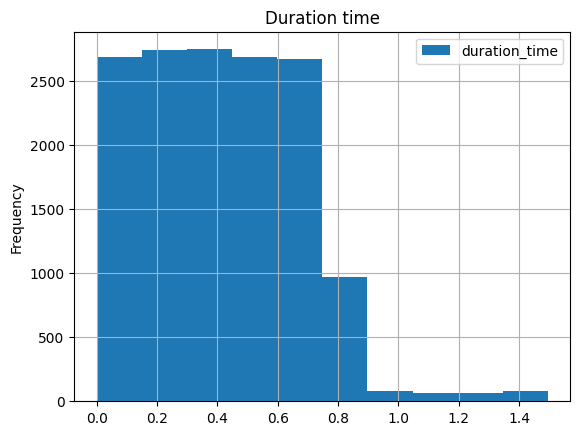

In [709]:
root_df.plot(
    x="timestamp",
    y="duration_time",
    grid=True,
    title="Duration time",
    kind="hist",
    label='duration_time'
)
# plt.show()

Từ histogram có thể thấy độ phủ request duration rơi nhiều vào các bucket từ 0.1 -> 0.7. Tuy nhiên, vẫn có khá nhiều request có duration_time lớn (request mất nhiều thời gian xử lý) trong dataset trong khoảng từ [1 -> 1.6 seconds] (khoảng tầm 200 requests)


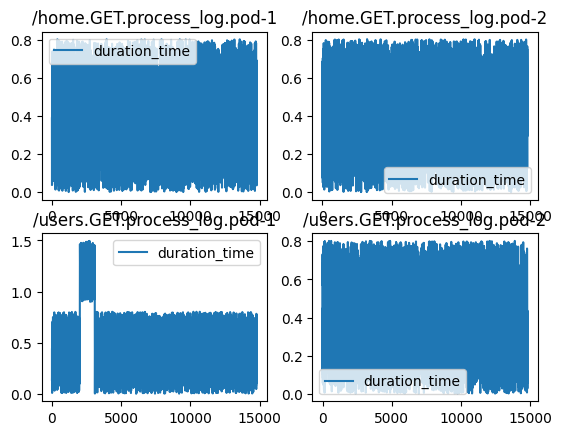

In [731]:
fig, axes = plt.subplots(nrows=2, ncols=2)
grouped = root_df.groupby(group_by_el)
for (name, df), ax in zip(grouped, axes.flatten()):
    df.plot(y='duration_time', ax=ax, title=".".join(name))

### Standardlize data

In [604]:
# Re format timestamp to  "%d/%m/%Y, %H:%M:%S"
from datetime import datetime
root_df['timestamp'] = root_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))
# Convert to datetime pandas and set datetime columns is index for dataframe
root_df['timestamp'] = pd.to_datetime(root_df['timestamp'])
root_df = root_df.set_index('timestamp')

In [605]:
# Bins data to bucket latency
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [606]:
root_df.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-30 16:41:33': '2024-01-30 16:45:30'][0:50]

,path,method,service_name,controller_pod,duration_time,le
timestamp,,,,,,
2024-01-30 16:41:33,/users,GET,process_log,pod-1,0.014,"[0.025, 0.05, 0.1, 0.25, 0.5, +Inf]"
2024-01-30 16:41:34,/users,GET,process_log,pod-1,0.141,"[0.25, 0.5, +Inf]"
2024-01-30 16:41:34,/users,GET,process_log,pod-1,1.331,[+Inf]
2024-01-30 16:41:35,/users,GET,process_log,pod-1,1.089,[+Inf]
2024-01-30 16:41:35,/users,GET,process_log,pod-1,1.201,[+Inf]
2024-01-30 16:41:35,/users,GET,process_log,pod-1,1.218,[+Inf]
2024-01-30 16:41:35,/users,GET,process_log,pod-1,0.870,[+Inf]
2024-01-30 16:41:36,/users,GET,process_log,pod-1,1.081,[+Inf]
2024-01-30 16:41:36,/users,GET,process_log,pod-1,1.153,[+Inf]


In [608]:
# Get distinct group for bins value latency for each group
group_dataset = root_df.groupby(group_by_el).count().reset_index()[group_by_el]

In [609]:
group_dataset # <- Return all group existed in dataset, next step do bins value of each group into bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]** 

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [610]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # unwind data from list
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row

In [611]:
# Bins value to bucket latency
df_by_group = {}
for idx, dataset in group_dataset.iterrows():
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    # Query for each group get dataframe and save it to datastructure
    df_by_group[idx] = root_df.query(
        "path == @dataset['path'] \
                and method == @dataset['method'] \
                and service_name == @dataset['service_name'] \
                and controller_pod == @dataset['controller_pod']")\
        .apply(lambda x: bins_value(x, bins_dict), axis=1)

# Join all group dataframe processed by one dataframe
raw_df = pd.concat(df_by_group.values())

In [612]:
# Rename columns
columns_change = {
    0.005: "le_0.005",
    0.01: "le_0.01",
    0.025: "le_0.025",
    0.05: "le_0.05",
    0.1: "le_0.1",
    0.25: "le_0.25",
    0.5: "le_0.5",
    "+Inf": "+Inf"
}
raw_df = raw_df.rename(columns=columns_change)

In [613]:
raw_df

,path,method,service_name,controller_pod,duration_time,le,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,,,
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0.104,"[0.25, 0.5, +Inf]",0,0,0,0,0,1,1,1
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0.528,[+Inf],0,0,0,0,0,1,1,2
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0.667,[+Inf],0,0,0,0,0,1,1,3
2024-01-30 16:41:24,/home,GET,process_log,pod-1,0.369,"[0.5, +Inf]",0,0,0,0,0,1,2,4
2024-01-30 16:41:24,/home,GET,process_log,pod-1,0.145,"[0.25, 0.5, +Inf]",0,0,0,0,0,2,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 16:48:36,/users,GET,process_log,pod-2,0.130,"[0.25, 0.5, +Inf]",5,9,35,59,114,319,613,974
2024-01-30 16:48:36,/users,GET,process_log,pod-2,0.758,[+Inf],5,9,35,59,114,319,613,975
2024-01-30 16:48:36,/users,GET,process_log,pod-2,0.737,[+Inf],5,9,35,59,114,319,613,976


In [614]:
# Select columns necessary for analysis
list_column_select = ["path", "method", "service_name",
                      "controller_pod"] + [bucket for bucket in columns_change.values()]
raw_df = raw_df[list_column_select]

In [615]:
raw_df

,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,2
2024-01-30 16:41:23,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,3
2024-01-30 16:41:24,/home,GET,process_log,pod-1,0,0,0,0,0,1,2,4
2024-01-30 16:41:24,/home,GET,process_log,pod-1,0,0,0,0,0,2,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 16:48:36,/users,GET,process_log,pod-2,5,9,35,59,114,319,613,974
2024-01-30 16:48:36,/users,GET,process_log,pod-2,5,9,35,59,114,319,613,975
2024-01-30 16:48:36,/users,GET,process_log,pod-2,5,9,35,59,114,319,613,976


,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-30 16:41:33,/users,GET,process_log,pod-1,0,0,1,1,2,4,15,26
2024-01-30 16:41:34,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,28
2024-01-30 16:41:35,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,32
2024-01-30 16:41:36,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,35
2024-01-30 16:41:38,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,38
2024-01-30 16:41:39,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,39
2024-01-30 16:41:40,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,40
2024-01-30 16:41:41,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,42
2024-01-30 16:41:42,/users,GET,process_log,pod-1,0,0,1,1,2,5,16,46


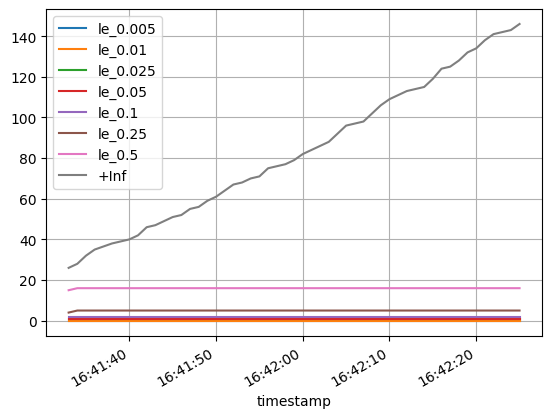

In [649]:
# Query data anomaly by time range
raw_df.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-30 16:41:33': '2024-01-30 16:45:30'][0:50].plot(grid=True)

raw_df.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-30 16:41:33': '2024-01-30 16:45:30'][0:50]

In [622]:
# Group data interval 1 second
# Only consider about latency bucket -> Get newest value increament by second
df_interval = raw_df.groupby(["timestamp"] + group_by_el).nth(-1)

<Axes: xlabel='timestamp'>

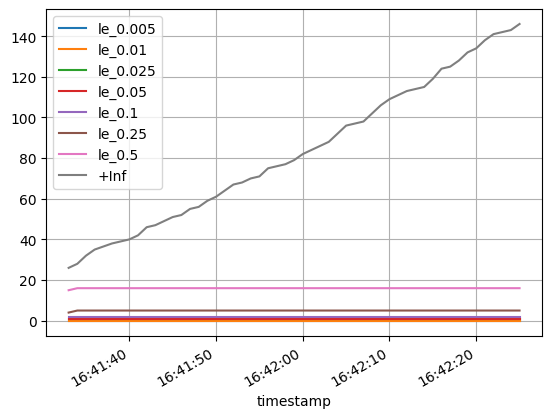

In [654]:
df_interval.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-30 16:41:33': '2024-01-30 16:45:30'][0:50].plot(grid=True)

In [624]:
# Implement pct change for each bucket
raw_df_rolling = df_interval.groupby(group_by_el).rolling(window="5s").agg(lambda x: (x[-1] - x[0]) / x[0])  # type: ignore

<Axes: xlabel='timestamp'>

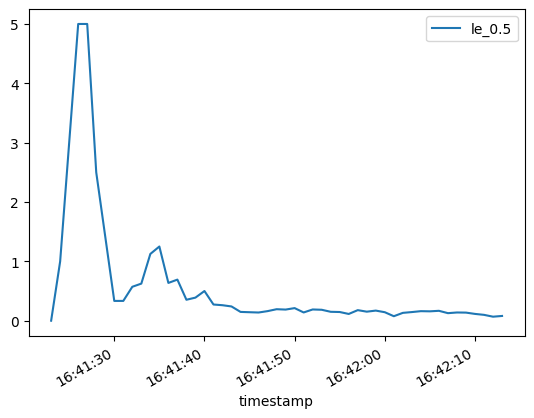

In [663]:
raw_df_rolling.query("path == '/users' and controller_pod == 'pod-2'").fillna(0).reset_index()[0:50] \
.plot(x="timestamp", y="le_0.5")